## t-SNE of the last layer before classication head

In [2]:
from fileinput import filename
from operator import index
import click
import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path


import torch
from torchvision.models import resnet50,densenet121
from torch.nn.functional import sigmoid
from sklearn.metrics import roc_auc_score,f1_score

from torch.utils.data import DataLoader
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from src.data.pytorch_dataset import MaskingDataset
from sklearn.manifold import TSNE
from torchvision.models.feature_extraction import create_feature_extractor

import shap
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/theo/miniconda3/envs/mmc_masking/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



NoDiscBB_0

NoDiscDataset_0

NormalDataset

OnlyDisc_0

OnlyDiscBB_0


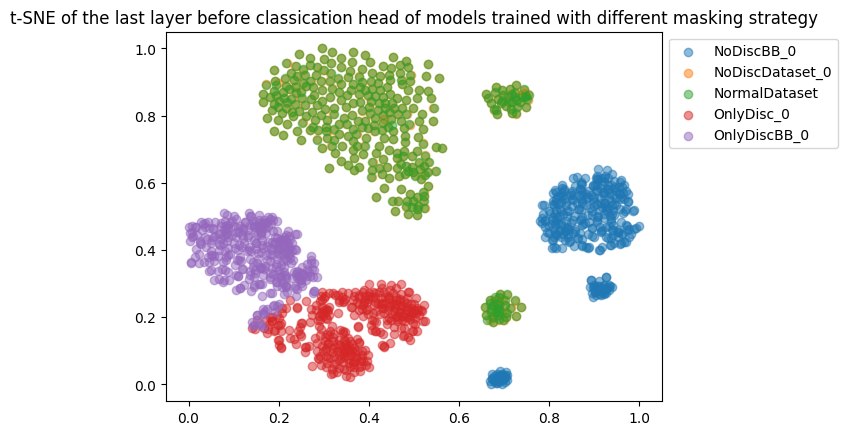

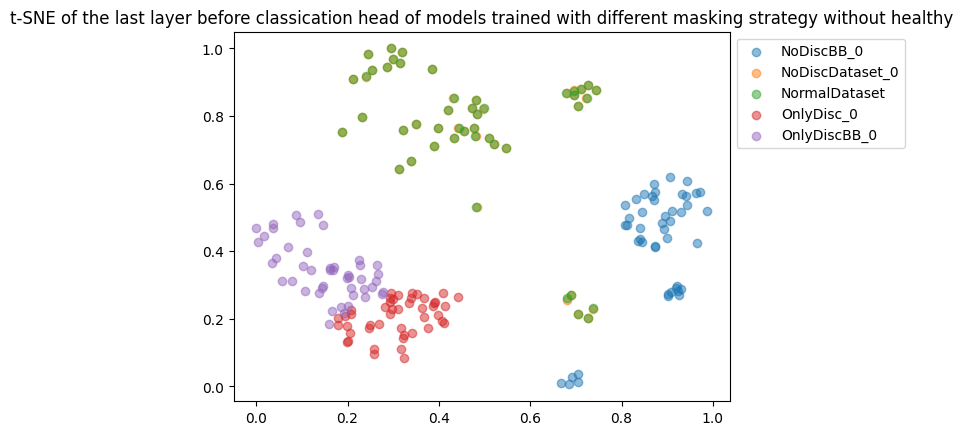

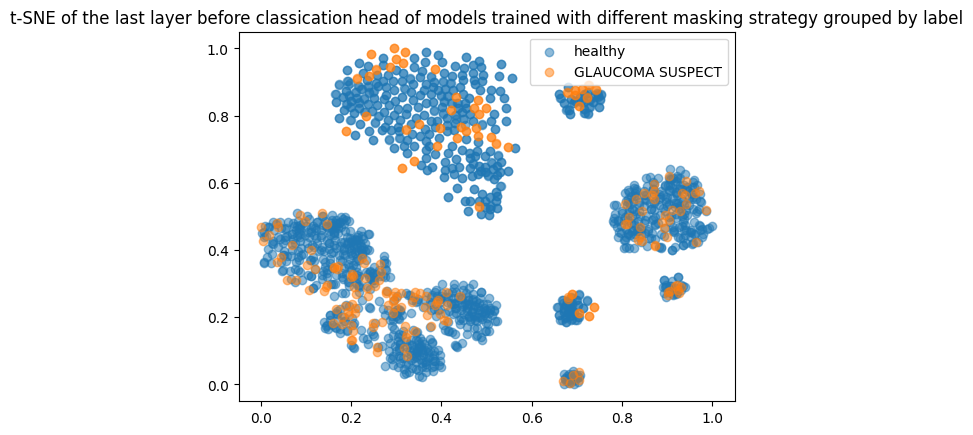

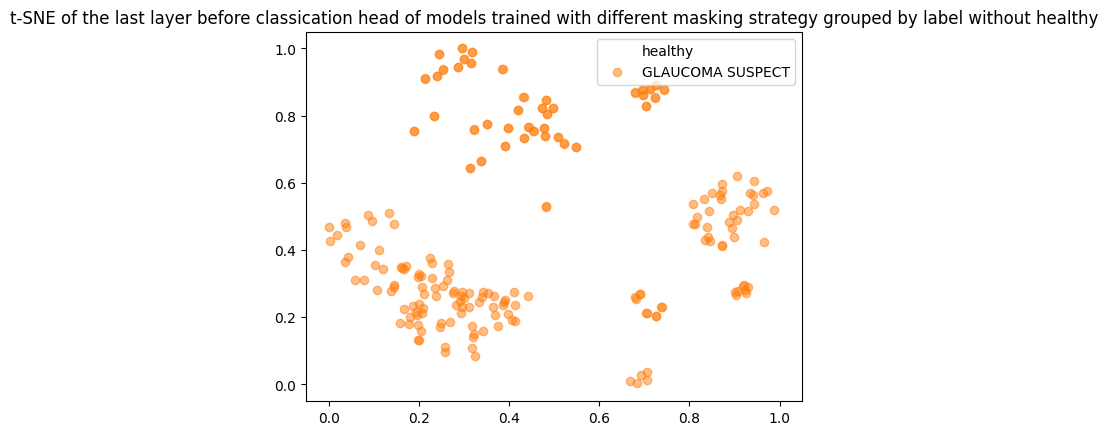

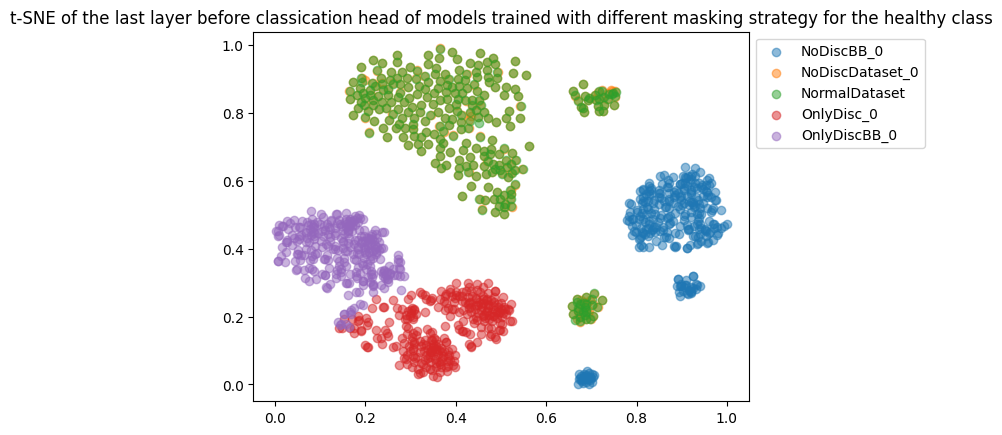

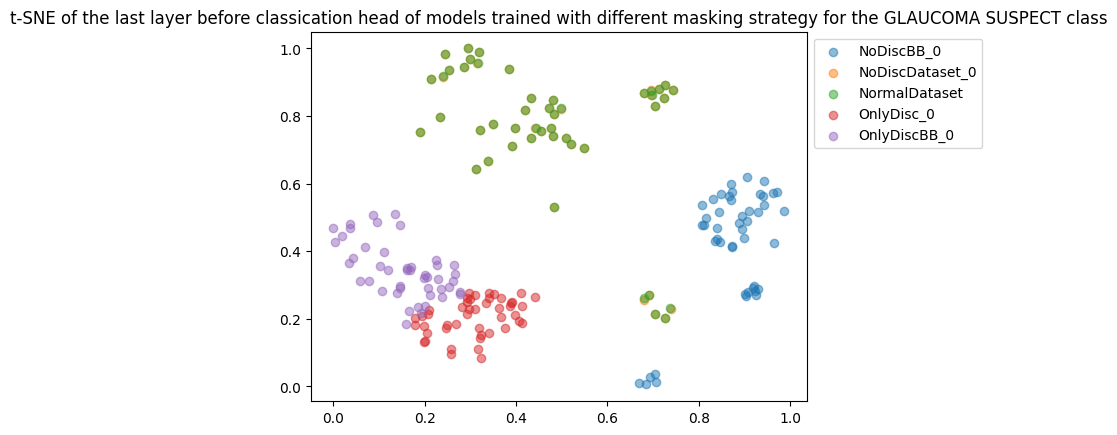

In [6]:
def plot_tsne():
    NB_FOLDS = int(os.environ.get("NB_FOLDS"))
    BATCH_SIZE = int(os.environ.get("BATCH_SIZE"))
    CLASSES = os.environ.get("CLASSES").split(",")
    models_names=["NoDiscBB_0","NoDiscDataset_0","NormalDataset","OnlyDisc_0","OnlyDiscBB_0"]
    
    #Load the base dataset
    training_data = MaskingDataset(data_dir="../data/processed/Train")
    testing_data = MaskingDataset(data_dir="../data/processed/Test")
    y = np.array(training_data.img_labels["Onehot"].tolist())[:,0]


    #Create k-fold for train/val
    stratified_group_kfold = StratifiedGroupKFold(n_splits=NB_FOLDS)
    
    valid_params={
        "NormalDataset":{"masking_spread":None,"inverse_roi":False,"bounding_box":False},
        "NoDiscDataset_0":{"masking_spread":0,"inverse_roi":False,"bounding_box":False},
        "NoDiscBB_0":{"masking_spread":0,"inverse_roi":False,"bounding_box":True},
        "OnlyDisc_0":{"masking_spread":0,"inverse_roi":True,"bounding_box":False},
        "OnlyDiscBB_0":{"masking_spread":0,"inverse_roi":True,"bounding_box":True},
    }
    
    models_flatten_output = []
    label_models = []
    labels_dataset = []
    for model_name in models_names:
        print(f"\n{model_name}")
        for i, (train_index,val_index) in enumerate(stratified_group_kfold.split(X=training_data.img_labels, y=y, groups= training_data.img_labels['PatientID'])):
            val_data = MaskingDataset(data_dir="../data/processed/Train",**valid_params[model_name])
            val_data.img_labels = training_data.img_labels.iloc[val_index].reset_index(drop=True)
            val_data.img_paths = np.array(training_data.img_paths)[val_index]
            val_data.roi_paths = np.array(training_data.roi_paths)[val_index]

            valid_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)
            
            
            #Define model, loss and optimizer
            model = densenet121(weights='DEFAULT')#Weights pretrained on imagenet_1k
            
            # Freeze every layer except last denseblock and classifier
            for param in model.parameters():
                param.requires_grad = False
            for param in model.features.denseblock4.denselayer16.parameters():
                param.requires_grad = True
           
            kernel_count = model.classifier.in_features
            model.classifier = torch.nn.Sequential(
             torch.nn.Flatten(),
             torch.nn.Linear(kernel_count, len(CLASSES))
            )
            
            try:
                model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold{i}.pt"))
                model.to(DEVICE)
            except FileNotFoundError as e:
                print("No model saved for fold",i)
                continue
            
            return_nodes = {
                "classifier.0": "flatten"
            }
            model = create_feature_extractor(model,return_nodes)
            model.eval()
            with torch.no_grad():
                for i, data in enumerate(valid_dataloader, 0):
                    inputs, labels = data
                    inputs,labels = inputs.float().to(DEVICE), torch.Tensor(np.array(labels)).float().to(DEVICE)
                    outputs = model(inputs)
                    models_flatten_output.extend(outputs["flatten"].detach().cpu().tolist())
                    label_models += len(inputs)*[model_name]  
                    labels_dataset += labels
            break
    models_flatten_output = np.array(models_flatten_output)

    #Taken from https://learnopencv.com/t-sne-for-feature-visualization/
    tsne = TSNE(n_components=2).fit_transform(np.array(models_flatten_output))
    # scale and move the coordinates so they fit [0; 1] range
    def scale_to_01_range(x):
        # compute the distribution range
        value_range = (np.max(x) - np.min(x))
     
        # move the distribution so that it starts from zero
        # by extracting the minimal value from all its values
        starts_from_zero = x - np.min(x)
     
        # make the distribution fit [0; 1] by dividing by its range
        return starts_from_zero / value_range
     
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]
     
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)


    #Plot divided just by model
    plt.figure()
    for model_name in models_names:
        indices = [j for j, l in enumerate(label_models) if l == model_name]
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        plt.scatter(current_tx,current_ty,label=model_name,alpha=0.5)
    plt.title(f"t-SNE of the last layer before classication head of models trained with different masking strategy")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    #Plot divided just by model without healthy
    plt.figure()
    for model_name in models_names:
        class_indices = set([j for j, l in enumerate(labels_dataset) if sum(l) != 0 ])
        model_indices = set([j for j, l in enumerate(label_models) if l == model_name])

        indices = list(class_indices & model_indices)
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        plt.scatter(current_tx,current_ty,label=model_name,alpha=0.5)
    plt.title(f"t-SNE of the last layer before classication head of models trained with different masking strategy without healthy")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    #Plot divided jusy by labels
    plt.figure()
    indices = [j for j, l in enumerate(labels_dataset) if sum(l) == 0 ]
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    plt.scatter(current_tx,current_ty,label="healthy",alpha=0.5)
    for i,c in enumerate(CLASSES):
        indices = [j for j, l in enumerate(labels_dataset) if l[i] == 1]
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        plt.scatter(current_tx,current_ty,label=c,alpha=0.5)
    plt.title(f"t-SNE of the last layer before classication head of models trained with different masking strategy grouped by label")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    #Plot divided jusy by labels without healthy
    plt.figure()
    indices = [j for j, l in enumerate(labels_dataset) if sum(l) == 0 ]
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    plt.scatter(current_tx,current_ty,label="healthy",alpha=0)
    for i,c in enumerate(CLASSES):
        indices = [j for j, l in enumerate(labels_dataset) if l[i] == 1]
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        plt.scatter(current_tx,current_ty,label=c,alpha=0.5)
    plt.title(f"t-SNE of the last layer before classication head of models trained with different masking strategy grouped by label without healthy")
    plt.legend()
    plt.show()
    
    
    #Plot divided per model and label
    plt.figure()
    for model_name in models_names:
        class_indices = set([j for j, l in enumerate(labels_dataset) if sum(l) == 0 ])
        model_indices = set([j for j, l in enumerate(label_models) if l == model_name])

        indices = list(class_indices & model_indices)
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        plt.scatter(current_tx,current_ty,label=model_name,alpha=0.5)
    plt.title(f"t-SNE of the last layer before classication head of models trained with different masking strategy for the healthy class")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    
    for i,c in enumerate(CLASSES):
        plt.figure()
        for model_name in models_names:
            class_indices = set([j for j, l in enumerate(labels_dataset) if l[i] == 1])
            model_indices = set([j for j, l in enumerate(label_models) if l == model_name])

            indices = list(class_indices & model_indices)
            # extract the coordinates of the points of this class only
            current_tx = np.take(tx, indices)
            current_ty = np.take(ty, indices)
            plt.scatter(current_tx,current_ty,label=model_name,alpha=0.5)
        plt.title(f"t-SNE of the last layer before classication head of models trained with different masking strategy for the {c} class")
        plt.legend(bbox_to_anchor=(1,1))
        plt.show()
        

def main():
    plot_tsne()

if __name__ == '__main__':
    load_dotenv(find_dotenv())
    main()

## With the same model


NormalDataset

NoDiscDataset_0

NoDiscBB_0

OnlyDisc_0

OnlyDiscBB_0
['NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalDataset', 'NormalData

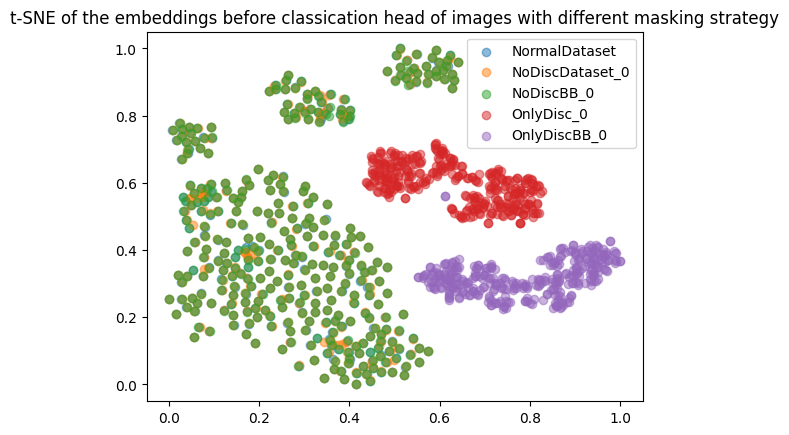

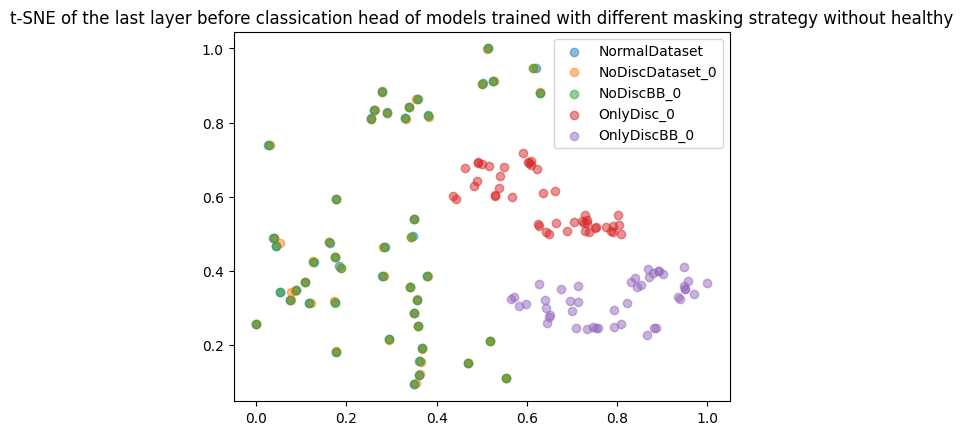

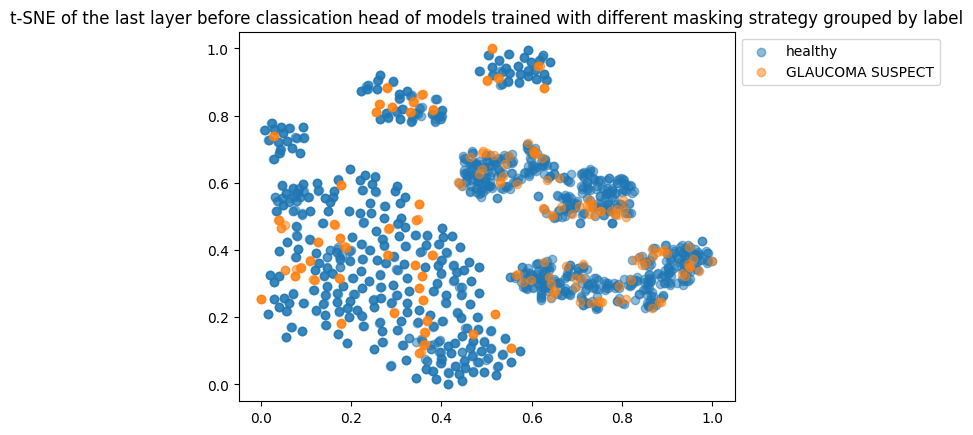

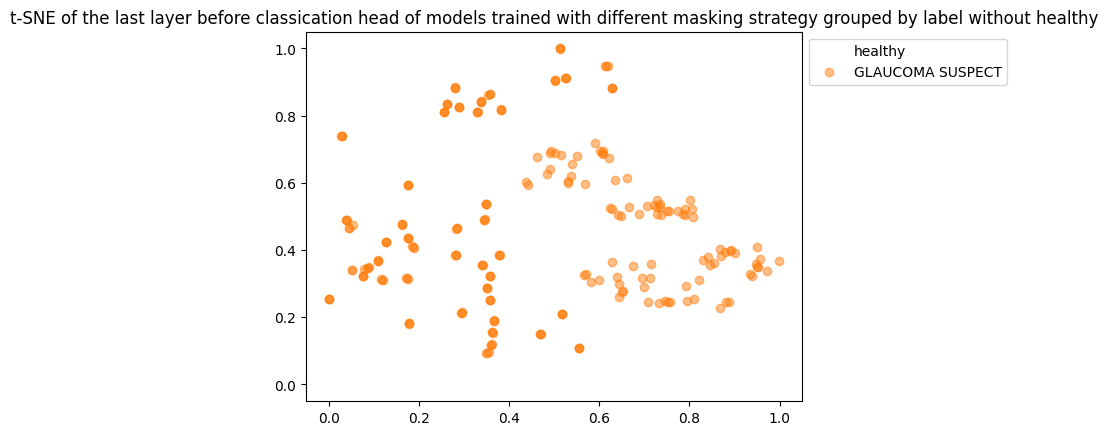

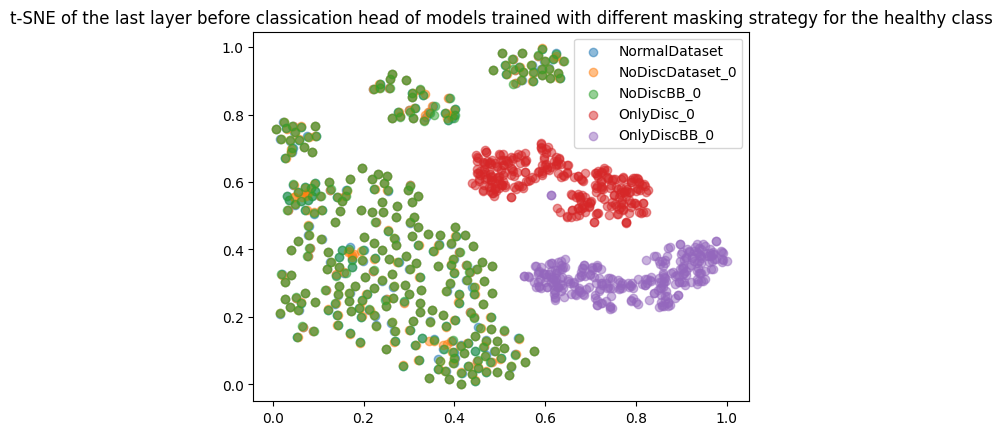

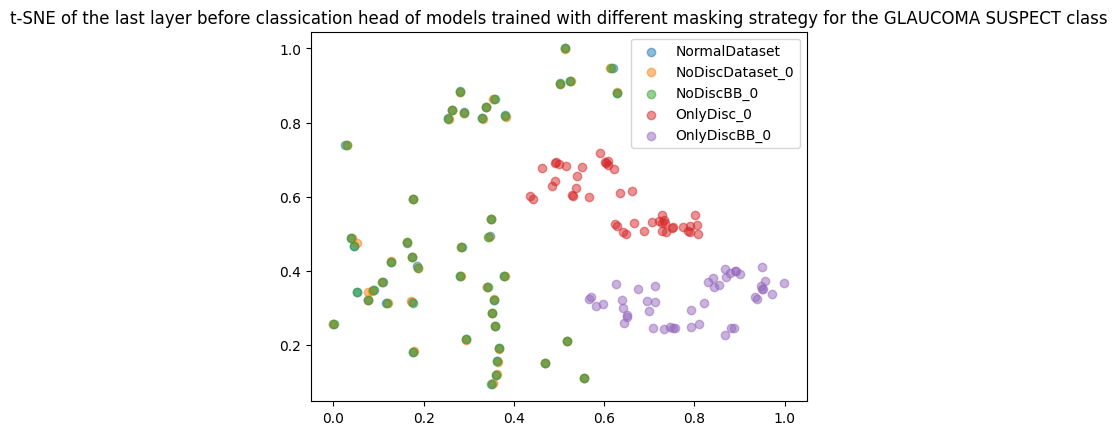

In [5]:
def plot_tsne():
    NB_FOLDS = int(os.environ.get("NB_FOLDS"))
    BATCH_SIZE = int(os.environ.get("BATCH_SIZE"))
    CLASSES = os.environ.get("CLASSES").split(",")
    model_name="NormalDataset"
    
    #Load the base dataset
    training_data = MaskingDataset(data_dir="../data/processed/Train")
    testing_data = MaskingDataset(data_dir="../data/processed/Test")
    y = np.array(training_data.img_labels["Onehot"].tolist())[:,0]


    #Create k-fold for train/val
    stratified_group_kfold = StratifiedGroupKFold(n_splits=NB_FOLDS)
    
    valid_params={
        "NormalDataset":{"masking_spread":None,"inverse_roi":False,"bounding_box":False},
        "NoDiscDataset_0":{"masking_spread":0,"inverse_roi":False,"bounding_box":False},
        "NoDiscBB_0":{"masking_spread":0,"inverse_roi":False,"bounding_box":True},
        "OnlyDisc_0":{"masking_spread":0,"inverse_roi":True,"bounding_box":False},
        "OnlyDiscBB_0":{"masking_spread":0,"inverse_roi":True,"bounding_box":True},
    }
    
    models_flatten_output = []
    label_masking = []
    labels_dataset = []
    for masking_param in valid_params:
        print(f"\n{masking_param}")
        for i, (train_index,val_index) in enumerate(stratified_group_kfold.split(X=training_data.img_labels, y=y, groups= training_data.img_labels['PatientID'])):
            val_data = MaskingDataset(data_dir="../data/processed/Train",**valid_params[masking_param])
            val_data.img_labels = training_data.img_labels.iloc[val_index].reset_index(drop=True)
            val_data.img_paths = np.array(training_data.img_paths)[val_index]
            val_data.roi_paths = np.array(training_data.roi_paths)[val_index]

            valid_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)
            
            
            #Define model, loss and optimizer
            model = densenet121(weights='DEFAULT')#Weights pretrained on imagenet_1k
            
            # Freeze every layer except last denseblock and classifier
            for param in model.parameters():
                param.requires_grad = False
            for param in model.features.denseblock4.denselayer16.parameters():
                param.requires_grad = True
           
            kernel_count = model.classifier.in_features
            model.classifier = torch.nn.Sequential(
             torch.nn.Flatten(),
             torch.nn.Linear(kernel_count, len(CLASSES))
            )
            
            try:
                model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold{i}.pt"))
                model.to(DEVICE)
            except FileNotFoundError as e:
                print("No model saved for fold",i)
                continue
            
            return_nodes = {
                "classifier.0": "flatten"
            }
            model = create_feature_extractor(model,return_nodes)
            model.eval()
            with torch.no_grad():
                for i, data in enumerate(valid_dataloader, 0):
                    inputs, labels = data
                    inputs,labels = inputs.float().to(DEVICE), torch.Tensor(np.array(labels)).float().to(DEVICE)
                    outputs = model(inputs)
                    models_flatten_output.extend(outputs["flatten"].detach().cpu().tolist())
                    label_masking += len(inputs)*[masking_param]  
                    labels_dataset += labels
            break
    models_flatten_output = np.array(models_flatten_output)
    
    #Taken from https://learnopencv.com/t-sne-for-feature-visualization/
    tsne = TSNE(n_components=2,perplexity=10).fit_transform(np.array(models_flatten_output))
    # scale and move the coordinates so they fit [0; 1] range
    def scale_to_01_range(x):
        # compute the distribution range
        value_range = (np.max(x) - np.min(x))
     
        # move the distribution so that it starts from zero
        # by extracting the minimal value from all its values
        starts_from_zero = x - np.min(x)
     
        # make the distribution fit [0; 1] by dividing by its range
        return starts_from_zero / value_range
     
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]
     
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)


    #Plot divided just by model
    plt.figure()
    print(label_masking)
    for masking_param in valid_params:
        indices = [j for j, l in enumerate(label_masking) if l == masking_param]
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        plt.scatter(current_tx,current_ty,label=masking_param,alpha=0.5)
    plt.title(f"t-SNE of the embeddings before classication head of images with different masking strategy")
    plt.legend()
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    

    #Plot divided just by model without healthy
    plt.figure()
    for masking_param in valid_params:
        class_indices = set([j for j, l in enumerate(labels_dataset) if sum(l) != 0 ])
        model_indices = set([j for j, l in enumerate(label_masking) if l == masking_param])

        indices = list(class_indices & model_indices)
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        plt.scatter(current_tx,current_ty,label=masking_param,alpha=0.5)
    plt.title(f"t-SNE of the last layer before classication head of models trained with different masking strategy without healthy")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    
    #Plot divided jusy by labels
    plt.figure()
    indices = [j for j, l in enumerate(labels_dataset) if sum(l) == 0 ]
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    plt.scatter(current_tx,current_ty,label="healthy",alpha=0.5)
    for i,c in enumerate(CLASSES):
        indices = [j for j, l in enumerate(labels_dataset) if l[i] == 1]
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        plt.scatter(current_tx,current_ty,label=c,alpha=0.5)
    plt.title(f"t-SNE of the last layer before classication head of models trained with different masking strategy grouped by label")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    #Plot divided jusy by labels without healthy
    plt.figure()
    indices = [j for j, l in enumerate(labels_dataset) if sum(l) == 0 ]
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    plt.scatter(current_tx,current_ty,label="healthy",alpha=0)
    for i,c in enumerate(CLASSES):
        indices = [j for j, l in enumerate(labels_dataset) if l[i] == 1]
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        plt.scatter(current_tx,current_ty,label=c,alpha=0.5)
    plt.title(f"t-SNE of the last layer before classication head of models trained with different masking strategy grouped by label without healthy")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    
    
    #Plot divided per masking and label
    plt.figure()
    for masking_param in valid_params:
        class_indices = set([j for j, l in enumerate(labels_dataset) if sum(l) == 0 ])
        model_indices = set([j for j, l in enumerate(label_masking) if l == masking_param])

        indices = list(class_indices & model_indices)
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        plt.scatter(current_tx,current_ty,label=masking_param,alpha=0.5)
    plt.title(f"t-SNE of the last layer before classication head of models trained with different masking strategy for the healthy class")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    
    for i,c in enumerate(CLASSES):
        plt.figure()
        for masking_param in valid_params:
            class_indices = set([j for j, l in enumerate(labels_dataset) if l[i] == 1])
            model_indices = set([j for j, l in enumerate(label_masking) if l == masking_param])

            indices = list(class_indices & model_indices)
            # extract the coordinates of the points of this class only
            current_tx = np.take(tx, indices)
            current_ty = np.take(ty, indices)
            plt.scatter(current_tx,current_ty,label=masking_param,alpha=0.5)
        plt.title(f"t-SNE of the last layer before classication head of models trained with different masking strategy for the {c} class")
        plt.legend(bbox_to_anchor=(1,1))
        plt.show()
    return
        

def main():
    plot_tsne()

if __name__ == '__main__':
    load_dotenv(find_dotenv())
    main()

Cosine similarity

In [1]:
from fileinput import filename
from operator import index
import click
import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path


import torch
from torchvision.models import resnet50,densenet121
from torch.nn.functional import sigmoid
from sklearn.metrics import roc_auc_score,f1_score

from torch.utils.data import DataLoader
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from src.data.pytorch_dataset import MaskingDataset
from sklearn.manifold import TSNE
from torchvision.models.feature_extraction import create_feature_extractor
from scipy.linalg import sqrtm
from scipy.spatial.distance import cosine

import shap
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_embedding(model_name,valid_params):
    NB_FOLDS = int(os.environ.get("NB_FOLDS"))
    BATCH_SIZE = int(os.environ.get("BATCH_SIZE"))
    CLASSES = os.environ.get("CLASSES").split(",")
    
    #Load the base dataset
    training_data = MaskingDataset(data_dir="../data/processed/Train")
    testing_data = MaskingDataset(data_dir="../data/processed/Test")

    y = np.array(training_data.img_labels["Onehot"].tolist())[:,0]

    #Create k-fold for train/val
    stratified_group_kfold = StratifiedGroupKFold(n_splits=NB_FOLDS)
    
    
    models_flatten_output = {
        masking_param:[] for masking_param in valid_params
    }
    
    for masking_param in valid_params:
        print(f"\n{masking_param}")
        for i, (train_index,val_index) in enumerate(stratified_group_kfold.split(X=training_data.img_labels, y=y, groups= training_data.img_labels['PatientID'])):
            val_data = MaskingDataset(data_dir="../data/processed/Train",**valid_params[masking_param])
            val_data.img_labels = training_data.img_labels.iloc[val_index].reset_index(drop=True)
            val_data.img_paths = np.array(training_data.img_paths)[val_index]
            val_data.roi_paths = np.array(training_data.roi_paths)[val_index]

            valid_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)
            
            
            #Define model, loss and optimizer
            model = densenet121(weights='DEFAULT')#Weights pretrained on imagenet_1k
            
            # Freeze every layer except last denseblock and classifier
            for param in model.parameters():
                param.requires_grad = False
            for param in model.features.denseblock4.denselayer16.parameters():
                param.requires_grad = True
           
            kernel_count = model.classifier.in_features
            model.classifier = torch.nn.Sequential(
             torch.nn.Flatten(),
             torch.nn.Linear(kernel_count, len(CLASSES))
            )
            
            try:
                model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold{i}.pt"))
                model.to(DEVICE)
            except FileNotFoundError as e:
                print("No model saved for fold",i)
                continue
            
            return_nodes = {
                "classifier.0": "flatten"
            }
            model = create_feature_extractor(model,return_nodes)
            model.eval()
            with torch.no_grad():
                labels_dataset = []
                for i, data in enumerate(valid_dataloader, 0):
                    inputs, labels = data
                    inputs,labels = inputs.float().to(DEVICE), torch.Tensor(np.array(labels)).float().to(DEVICE)
                    outputs = model(inputs)
                    models_flatten_output[masking_param].extend(outputs["flatten"].detach().cpu().tolist())
                    labels_dataset += labels
            models_flatten_output[masking_param] = np.array(models_flatten_output[masking_param])
            break
    return models_flatten_output, labels_dataset


def get_cosine():
    model_name="NormalDataset"
    
    valid_params={
        "Normal":{"masking_spread":None,"inverse_roi":False,"bounding_box":False},
        "NoDisc":{"masking_spread":0,"inverse_roi":False,"bounding_box":False},
        "NoDiscBB":{"masking_spread":0,"inverse_roi":False,"bounding_box":True},
        "OnlyDisc":{"masking_spread":0,"inverse_roi":True,"bounding_box":False},
        "OnlyDiscBB":{"masking_spread":0,"inverse_roi":True,"bounding_box":True}
    }
    CLASSES = os.environ.get("CLASSES").split(",")
    
    models_flatten_output,labels_dataset = get_embedding(model_name,valid_params)

    no_disc_similarities = []
    only_disc_similarities = []
    no_discbb_similarities = []
    only_discbb_similarities = []
    for j in range(len(models_flatten_output["Normal"])):
        normal = models_flatten_output["Normal"][j]
        nodisc = models_flatten_output["NoDisc"][j]
        nodiscbb = models_flatten_output["NoDiscBB"][j]
        onlydisc = models_flatten_output["OnlyDisc"][j]
        onlydiscbb = models_flatten_output["OnlyDiscBB"][j]
        
        no_disc_similarities.append(1- cosine(normal,nodisc))
        no_discbb_similarities.append(1- cosine(normal,nodiscbb))
        only_disc_similarities.append(1- cosine(normal,onlydisc))
        only_discbb_similarities.append(1- cosine(normal,onlydiscbb))
    print(f"all,{np.mean(no_disc_similarities)}+/-{np.std(no_disc_similarities)},\
            {np.mean(no_discbb_similarities)}+/-{np.std(no_discbb_similarities)},\
            {np.mean(only_disc_similarities)}+/-{np.std(only_disc_similarities)},\
            {np.mean(only_discbb_similarities)}+/-{np.std(only_discbb_similarities)}")

    #Per class
    for i,c in enumerate(CLASSES):
        no_disc_similarities = []
        only_disc_similarities = []
        no_discbb_similarities = []
        only_discbb_similarities = []
        class_indices = [j for j, l in enumerate(labels_dataset) if l[i] == 1]
        for j in class_indices:
            normal = models_flatten_output["Normal"][j]
            nodisc = models_flatten_output["NoDisc"][j]
            nodiscbb = models_flatten_output["NoDiscBB"][j]
            onlydisc = models_flatten_output["OnlyDisc"][j]
            onlydiscbb = models_flatten_output["OnlyDiscBB"][j]
            
            no_disc_similarities.append(1- cosine(normal,nodisc))
            no_discbb_similarities.append(1- cosine(normal,nodiscbb))
            only_disc_similarities.append(1- cosine(normal,onlydisc))
            only_discbb_similarities.append(1- cosine(normal,onlydiscbb))
        print(f"{c},{np.mean(no_disc_similarities)}+/-{np.std(no_disc_similarities)},\
            {np.mean(no_discbb_similarities)}+/-{np.std(no_discbb_similarities)},\
            {np.mean(only_disc_similarities)}+/-{np.std(only_disc_similarities)},\
            {np.mean(only_discbb_similarities)}+/-{np.std(only_discbb_similarities)}")
        
def main():
    get_cosine()

if __name__ == '__main__':
    load_dotenv(find_dotenv())
    main()

/home/theo/miniconda3/envs/mmc_masking/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Normal

NoDisc

NoDiscBB

OnlyDisc

OnlyDiscBB
all,0.9740390613975665+/-0.007482368665251653,            0.9789408295768084+/-0.006074361387113032,            0.6953891021006765+/-0.034556532624800546,            0.6774476191190023+/-0.03332045988558208
GLAUCOMA SUSPECT,0.9723093297927424+/-0.00735863076548699,            0.9781880576192536+/-0.006618518815120062,            0.7077798748425659+/-0.03806755626375708,            0.6882049798422665+/-0.03336911453008223


## Compare with random noise

In [7]:
from fileinput import filename
from operator import index
import click
import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path


import torch
from torchvision.models import resnet50,densenet121
from torch.nn.functional import sigmoid
from sklearn.metrics import roc_auc_score,f1_score

from torch.utils.data import DataLoader
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from src.data.pytorch_dataset import MaskingDataset
from sklearn.manifold import TSNE
from torchvision.models.feature_extraction import create_feature_extractor
from scipy.linalg import sqrtm
from scipy.spatial.distance import cosine

import shap
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_embedding(model_name,valid_params):
    NB_FOLDS = int(os.environ.get("NB_FOLDS"))
    BATCH_SIZE = int(os.environ.get("BATCH_SIZE"))
    CLASSES = os.environ.get("CLASSES").split(",")
    
    #Load the base dataset
    training_data = MaskingDataset(data_dir="../data/processed/Train")
    testing_data = MaskingDataset(data_dir="../data/processed/Test")

    y = np.array(training_data.img_labels["Onehot"].tolist())[:,0]

    #Create k-fold for train/val
    stratified_group_kfold = StratifiedGroupKFold(n_splits=NB_FOLDS)
    
    
    models_flatten_output = {
        masking_param:[] for masking_param in valid_params
    }
    
    for masking_param in valid_params:
        print(f"\n{masking_param}")
        for i, (train_index,val_index) in enumerate(stratified_group_kfold.split(X=training_data.img_labels, y=y, groups= training_data.img_labels['PatientID'])):
            val_data = MaskingDataset(data_dir="../data/processed/Train",**valid_params[masking_param])
            val_data.img_labels = training_data.img_labels.iloc[val_index].reset_index(drop=True)
            val_data.img_paths = np.array(training_data.img_paths)[val_index]
            val_data.roi_paths = np.array(training_data.roi_paths)[val_index]

            valid_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)
            
            
            #Define model, loss and optimizer
            model = densenet121(weights='DEFAULT')#Weights pretrained on imagenet_1k
            
            # Freeze every layer except last denseblock and classifier
            for param in model.parameters():
                param.requires_grad = False
            for param in model.features.denseblock4.denselayer16.parameters():
                param.requires_grad = True
           
            kernel_count = model.classifier.in_features
            model.classifier = torch.nn.Sequential(
             torch.nn.Flatten(),
             torch.nn.Linear(kernel_count, len(CLASSES))
            )
            
            try:
                model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold{i}.pt"))
                model.to(DEVICE)
            except FileNotFoundError as e:
                print("No model saved for fold",i)
                continue
            
            return_nodes = {
                "classifier.0": "flatten"
            }
            model = create_feature_extractor(model,return_nodes)
            model.eval()
            with torch.no_grad():
                labels_dataset = []
                for i, data in enumerate(valid_dataloader, 0):
                    inputs, labels = data
                    inputs,labels = inputs.float().to(DEVICE), torch.Tensor(np.array(labels)).float().to(DEVICE)
                    outputs = model(inputs)
                    models_flatten_output[masking_param].extend(outputs["flatten"].detach().cpu().tolist())
                    labels_dataset += labels
            models_flatten_output[masking_param] = np.array(models_flatten_output[masking_param])
            break
    return models_flatten_output, labels_dataset


def get_cosine():
    model_name="NormalDataset"
    #Define model, loss and optimizer
    model = densenet121(weights='DEFAULT')#Weights pretrained on imagenet_1k

    # Freeze every layer except last denseblock and classifier
    for param in model.parameters():
        param.requires_grad = False
    for param in model.features.denseblock4.denselayer16.parameters():
        param.requires_grad = True

    kernel_count = model.classifier.in_features
    model.classifier = torch.nn.Sequential(
     torch.nn.Flatten(),
     torch.nn.Linear(kernel_count, 1)
    )

    model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold0.pt"))
    model.to(DEVICE)

    return_nodes = {
        "classifier.0": "flatten"
    }
    model = create_feature_extractor(model,return_nodes)
    model.eval()
    valid_params={
        "Normal":{"masking_spread":None,"inverse_roi":False,"bounding_box":False},
    }
    CLASSES = os.environ.get("CLASSES").split(",")
    
    models_flatten_output,labels_dataset = get_embedding(model_name,valid_params)

    noise_similarities = []
    for j in range(len(models_flatten_output["Normal"])):
        normal_embedding = models_flatten_output["Normal"][j]
        row,col,ch= (3,512,512)
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch)).clip(0,1)
        gauss = torch.Tensor([gauss.reshape(row,col,ch)]).to(DEVICE)
        noise_embedding = model(gauss)["flatten"].detach().cpu().tolist()[0]
        noise_similarities.append(1- cosine(normal_embedding,noise_embedding))
    print(f"noise,{np.mean(noise_similarities)}+/-{np.std(noise_similarities)}")

def main():
    get_cosine()

if __name__ == '__main__':
    load_dotenv(find_dotenv())
    main()


Normal
ya tensor(False)
yo tensor(False, device='cuda:0')
noise,nan+/-nan


/home/theo/miniconda3/envs/mmc_masking/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/theo/miniconda3/envs/mmc_masking/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/theo/miniconda3/envs/mmc_masking/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/theo/miniconda3/envs/mmc_masking/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/theo/miniconda3/envs/mmc_masking/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
